In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import typing as t
from cycler import cycler
import numpy as np

In [15]:
df = pd.read_csv("results/all_experiments.csv")

In [16]:

# Select the experiments that we want to compare
selected = df[ (df["strategy"] == "taskInference") &
    (df["experiment_category"] == "PL") &
    (df["prune_proportion"] == "0.5") &
    (df["architecture"] == "AE") &
    (
        (df["dataset"] != "SE-CORe50") & (df["repo_hash"].isin(["1555acb6", "0a229afa", "4e7023cd", "4e7023cdD", "0a229afaD"])) |
        (df["dataset"] == "S-FMNIST") & (df["repo_hash"].isin(["54dcf601"])) |
        (df["dataset"] == "SE-CORe50") & (df["repo_hash"].isin(["1555acb6", "4e7023cd", "4e7023cdD"]))
    ) &
    (df["completed_tasks"] == df["n_experiences"])
]

# selected.groupby("dataset").count()

In [17]:
# Use cubehelix to get a nice color palette
colours = plt.cm.cubehelix(np.linspace(0.1, 0.9, 5))
plt.rcParams['axes.prop_cycle'] = cycler(color=colours)

# plt.rcParams['font.serif'] = ["Computer Modern Roman"]
plt.rcParams['font.family'] = 'serif'
# What font?
# print(plt.rcParams['font.serif'])

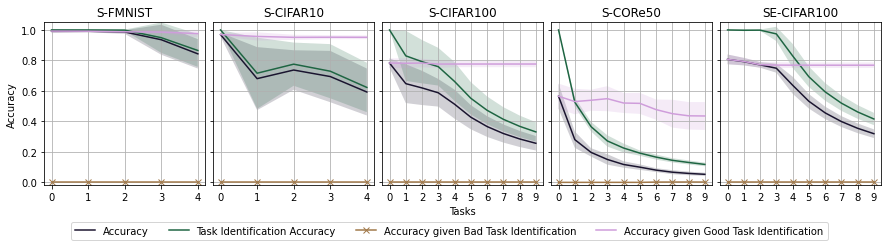

In [18]:
def mean_std(series: t.List[t.List[float]]):
    mean = [sum(x) / len(x) for x in zip(*series)]
    std = [np.std(x) for x in zip(*series)]
    return mean, std

def plot_with_std(ax, mean: t.List[float], std: t.List[float], label: str = None, style: str = "-"):
    ax.fill_between(range(len(mean)), np.subtract(mean, std), np.add(mean, std), alpha=0.2)
    return ax.plot(mean, style, label=label)

def eval_series(series):
    return series.apply(lambda x: eval(x, {"nan": 0}))

# Create 5 plots side by side
fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
fig.subplots_adjust(wspace=0.05)


# Loop over each dataset
for dataset, ax in zip(
    ["S-FMNIST", "S-CIFAR10", "S-CIFAR100", "S-CORe50", "SE-CIFAR100", "SE-CORe50"]
    , axs):

    # Select the data for the current dataset
    data = selected[selected["dataset"] == dataset]
    n_experiences = int(data["n_experiences"].iloc[0])

    def _get_metric(key):
        return mean_std(eval_series(data[key]))


    # Plot the mean and std for each metric
    plot_with_std(ax, *_get_metric("accuracy"), 
        label="Accuracy")
    plot_with_std(ax, *_get_metric("Task Identification Accuracy"), 
        label="Task Identification Accuracy")
    plot_with_std(ax, *_get_metric("Accuracy given Bad Task Identification"),
        label="Accuracy given Bad Task Identification",
        style="-x"
    )
    plot_with_std(ax, *_get_metric("Accuracy given Good Task Identification"),
        label="Accuracy given Good Task Identification"
    )


    ax.set_ylim(-0.02, 1.05)
    ax.set_title(dataset)
    # Add grid
    ax.grid()
    # x ticks
    ax.set_xticks(range(0, n_experiences, 1))
    

axs[0].set_ylabel("Accuracy")
axs[2].set_xlabel("Tasks")

# Add legend
fig.legend(
    *axs[0].get_legend_handles_labels(),
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.15),
)

# Save to pdf
plt.savefig("results/taskAccuracy.pdf", bbox_inches="tight", pad_inches=0)
# no padding


